<a href="https://colab.research.google.com/github/fbeilstein/machine_learning/blob/master/workbook_10_support_vector_machines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**How to use demo**
* Drag and drop color circles to set features on the field
* Dropping feature outside the field removes it
* Panels "class A" and "class B" contain infinite supply for features
* Press button to process features with SVM

**Problem**

Use the following demo to get intuition behind SVM.
Check how moving features changes the result.

* You can restart the upper block of code without restarting the visualization part.
This way you can alter parameters of SVM without changing features positon -- just press "Invoke SVM" after you modified and restarted the upper block of the code.

Be sure to check that you understand how margins softening influences the result. 
I have tested $C=10^{-5}$ as a soft margin and $C=10^5$ as a hard margin, but you are encouraged to test other values.


#Linear kernel

In [0]:
import numpy as np
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E5, max_iter=1000) # C=1E5 - very hard margin, c=1E-5 - very soft margin

def process_SVM(points, classes):
  # return plane gradient w
  # intercept (bias) b
  # and support vectors
  model.fit(points, classes)
  if model.fit_status_:
    return None
  return model.coef_[0], model.intercept_[0], model.support_vectors_

In [0]:
#@title Linear SVM
import numpy as np
import json

def invoke_SVM(pts):
  data = np.array(pts).reshape((-1, 3))
  X = data[:, :2]
  y = data[:, 2]
  p = process_SVM(X, y)
  if p is None:
    return IPython.display.JSON({})
  w, b, s_v = p
  #print(w, b, s_v)
  s_v = np.array2string(s_v.astype(int), separator=',')
  return IPython.display.JSON({'w0': str(w[0]), 'w1': str(w[1]), 'b': str(b), 'v': s_v})


import IPython
from google.colab import output

main_str_lin = '''
  <script type="application/javascript">
  
    var active_pt = null;
    var all_pts = [];
    var class_btn = [[650, 50], [650, 150], [650, 250], [650, 350], [650, 450]];
    var class_name = ["class A", "class B", "class C", "class D", "class E"];
    var class_color = ["rgba(210, 0, 0, 0.75)", "rgba(0, 0, 150, 0.75)", 
         "rgba(107, 142, 35, 0.95)", "rgba(150, 0, 150, 0.75)", "rgba(220, 105, 0, 0.75)"]

    var ptR = 10.0;
    var params = null;
    var debug_txt = "";
  
    function is_close(pt1, pt2) {
      return   (pt1[0] - pt2[0])*(pt1[0] - pt2[0])
            +  (pt1[1] - pt2[1])*(pt1[1] - pt2[1])
            <= ptR*ptR;
    }
  
    function circ(ctx, pos, cls) {
      ctx.beginPath();
      ctx.arc(pos[0], pos[1], ptR, 0.0, 2.0 * Math.PI, 0);
      ctx.fillStyle = class_color[cls];
      ctx.fill();
    }
    
    function gen_path(w0, w1, b) {
      var arr = [];
      
      var x = -b/w0;
      if (x >= 0 && x <= 600) { arr.push([Math.round(x), 0]); }
      x = -(b + w1*600.0)/w0;
      if (x >= 0 && x <= 600) { arr.push([Math.round(x), 600]); }
      var y = -b/w1;
      if (y >= 0 && y <= 600) { arr.push([0, Math.round(y)]); }
      y = -(b + w0*600.0)/w1;
      if (y >= 0 && y <= 600) { arr.push([600, Math.round(y)]); }
      
      return arr;
    }
    
    function gen_cls(w0, w1, b, sep_line, sign) {
          var half_rect = [];
          if (sign * (w0*0 + w1*0 + b) > 0) {half_rect.push([0, 0]);}
          if (sep_line[0][0] == 0) {half_rect.push(sep_line[0]);}
          if (sep_line[1][0] == 0) {half_rect.push(sep_line[1]);}
          if (sign * (w0*0 + w1*600 + b) > 0) {half_rect.push([0, 600]);}
          if (sep_line[0][1] == 600) {half_rect.push(sep_line[0]);}
          if (sep_line[1][1] == 600) {half_rect.push(sep_line[1]);}
          if (sign * (w0*600 + w1*600 + b) > 0) {half_rect.push([600, 600]);}
          if (sep_line[0][0] == 600) {half_rect.push(sep_line[0]);}
          if (sep_line[1][0] == 600) {half_rect.push(sep_line[1]);}
          if (sign * (w0*600 + w1*0 + b) > 0) {half_rect.push([600, 0]);}
          if (sep_line[0][1] == 0) {half_rect.push(sep_line[0]);}
          if (sep_line[1][1] == 0) {half_rect.push(sep_line[1]);}
          
          return half_rect;
    }
  
    function draw() {
      var canvas = document.getElementById('canvas');
      if (canvas.getContext) {
        var ctx = canvas.getContext('2d');
        
        ctx.clearRect(0, 0, canvas.width, canvas.height); // cleanup before start
        ctx.strokeRect(0, 0, 600, 600); // field

        ctx.fillText(debug_txt, 200, 200);

        if (active_pt) {
          circ(ctx, [active_pt[0], active_pt[1]], active_pt[2]);
        }
        all_pts.forEach(function (item, index) {
          circ(ctx, [item[0], item[1]], item[2]);
        });
        
        if (params) {
          var w0 = parseFloat(params.w0);
          var w1 = parseFloat(params.w1);
          var b = parseFloat(params.b);
          var sep_line = gen_path(w0, w1, b);
          ctx.fillStyle = 'black';
          if (sep_line.length >= 2) {
            ctx.beginPath();
            ctx.moveTo(sep_line[0][0], sep_line[0][1]);
            ctx.lineTo(sep_line[1][0], sep_line[1][1]);
            ctx.stroke();
          }
          
          ctx.setLineDash([5, 15]);
          var d_line = gen_path(w0, w1, b-1);
          if (d_line.length >= 2) {
            ctx.beginPath();
            ctx.moveTo(d_line[0][0], d_line[0][1]);
            ctx.lineTo(d_line[1][0], d_line[1][1]);
            ctx.stroke();
          }
          d_line = gen_path(w0, w1, b+1);
          if (d_line.length >= 2) {
            ctx.beginPath();
            ctx.moveTo(d_line[0][0], d_line[0][1]);
            ctx.lineTo(d_line[1][0], d_line[1][1]);
            ctx.stroke();
          }
          ctx.setLineDash([]);
          
          var half_rect = gen_cls(w0, w1, b, sep_line, 1);
          if (half_rect.length >= 3) {
            ctx.fillStyle = 'rgba(0, 0, 200, 0.1)';
            ctx.beginPath();
            ctx.moveTo(half_rect[0][0], half_rect[0][1]);
            for (var i = 1; i < half_rect.length; i++) {
              ctx.lineTo(half_rect[i][0], half_rect[i][1]);
            }
            ctx.fill();
          }
          
          half_rect = gen_cls(w0, w1, b, sep_line, -1);
          if (half_rect.length >= 3) {
            ctx.fillStyle = 'rgba(200, 0, 0, 0.1)';
            ctx.beginPath();
            ctx.moveTo(half_rect[0][0], half_rect[0][1]);
            for (var i = 1; i < half_rect.length; i++) {
              ctx.lineTo(half_rect[i][0], half_rect[i][1]);
            }
            ctx.fill();
          }
          
          //debug_txt = params.v;
          support_v = JSON.parse(params.v);
          
          //debug_txt = support_v[0][0].toString();
          support_v.forEach(function (item, index) {
            ctx.beginPath();
            ctx.arc(item[0], item[1], ptR/2.0, 0.0, 2.0 * Math.PI, 0);
            ctx.fillStyle = 'yellow';
            ctx.fill();
          });
         

        }
        
        
      }
    }
    
    var timer
    function init() {
      timer = setInterval(draw, 10);
    }

    function get_state() {
      var rates = document.getElementsByName('rate');
      for(var i = 0; i < rates.length; i++)
        if(rates[i].checked)
          return rates[i].value;
      return "none";
    }

    
    function mdown_handle(evt) {
      x = evt.offsetX;
      y = evt.offsetY;
      state = get_state();
      if (state.slice(0,3) == "add") {
        var class_idx = parseInt(state.slice(3,4), 10);
        if (x < 600)
            all_pts.push([x, y, class_idx]);
        return;
      }

      idx = -1;
      all_pts.forEach(function (item, index) {
        if (is_close([x,y], [item[0], item[1]])) {
          idx = index;
        }
      });
      if (idx <= -1)
          return;
      if (state == "move") {
        active_pt = all_pts[idx];
        all_pts.splice(idx, 1);
      }
      if (state == "del")
          all_pts.splice(idx, 1);
    }
    
    function mmove_handle(evt) {
      if (get_state() != "move")
          return;
      x = evt.offsetX;
      y = evt.offsetY;
      if (active_pt) {
        active_pt[0] = x;
        active_pt[1] = y;
      }
    }
    
    function mup_handle(evt) {
      if (get_state() != "move")
          return;
      x = evt.offsetX;
      y = evt.offsetY;
      if (x >= 600) {
        active_pt = null;
      }
      if (active_pt) {
        all_pts.push(active_pt);
        active_pt = null;
      }
    }
    
    function clear_field() {
      active_pt = null;
      all_pts = [];
    }

    async function calculate() {
      if (!all_pts)
        return;
      var merged = [].concat.apply([], all_pts);
      const result = await google.colab.kernel.invokeFunction('notebook.InvSVM', [merged], {});
      params = result.data['application/json'];
    }

  function getImageURL(class_idx)
  {
     var canvas = document.createElement('canvas');
     var ctx = canvas.getContext('2d');
     canvas.width  = 2.0 * ptR;
     canvas.height = 2.0 * ptR;
     circ(ctx, [ptR, ptR], class_idx);
     return canvas.toDataURL(); //image URL
  }

  </script>
  <canvas id="canvas" width="800" height="600" 
    onmousedown="mdown_handle(event)"
    onmousemove="mmove_handle(event)"
    onmouseup="mup_handle(event)"></canvas>
  <div style="position:absolute; top:200px; left:625px;">
   <div style="border-style: solid;">
    <input type="radio" id="r1" name="rate" value="add0" checked="checked"> 
    <img src="" onerror="this.onerror=null; this.src = getImageURL(0); "> Add class A
    <br>
    <input type="radio" id="r1" name="rate" value="add1"> 
    <img src="" onerror="this.onerror=null; this.src = getImageURL(1); "> Add class B
    <br>
    <input type="radio" id="r2" name="rate" value="move"> Move data point
    <br>
    <input type="radio" id="r3" name="rate" value="del"> Delete data point
    <br>
    <button type="button" onclick="clear_field();">
      Clear
    </button>
   </div>
   <br><br>
    <button type="button" onclick="calculate();">
      Invoke SVM
    </button>
  </div>
  <script> init();</script>
'''
  
display(IPython.display.HTML(main_str_lin))
    
output.register_callback('notebook.InvSVM', invoke_SVM)

#Arbitrary kernel

In [0]:
import numpy as np
from sklearn.svm import SVC # "Support vector classifier"

model = SVC(kernel='linear', C=1E5, gamma='auto')

def fit_model(X, y):
  model.fit(X, y)

def predict_result(X):
  return model.predict(X)

In [0]:
#@title Arbitrary Kernel SVM code

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


def visualize(X, y):
  fig = plt.figure(figsize=(10,10))
  ax = fig.gca()
  ax.tick_params(axis="y",direction="in", pad=-40)
  ax.tick_params(axis="x",direction="in", pad=-15)
  ax.set_xticks(np.arange(-.75, 1, .25))
  ax.set_yticks(np.arange(-.75, 1, .25))
  
  # Plot the training points
  rgb = [[210, 0, 0], [0, 0, 150], [107, 142, 35], [150, 0, 150], [220, 105, 0]]
    
  rgb=np.array(rgb)/255.
  ax.scatter(X[:, 0], X[:, 1], c=rgb[y], s=30, zorder=3)
  ax.axis('tight')
  xlim = [-1, +1]
  ylim = [-1, +1]
  ax.set_xlim(xlim)
  ax.set_ylim(ylim)
  
  # fit the estimator
  xx, yy = np.meshgrid(np.linspace(*xlim, num=700), np.linspace(*ylim, num=700))
  Z = predict_result(np.c_[xx.ravel(), yy.ravel()])

  # Put the result into a color plot
  n_classes = 5
  Z = Z.reshape(xx.shape)
  contours = ax.contourf(xx, yy, Z, alpha=0.3, levels=np.arange(n_classes + 1) - 0.5, cmap=ListedColormap(rgb), zorder=1)

  plt.close(fig)

  return fig

import base64
import io

def figure_to_base64(fig):
  buf = io.BytesIO()
  fig.savefig(buf, format='png', bbox_inches='tight', pad_inches=0);
  image_base64 = base64.b64encode(buf.getvalue()).decode('utf-8').replace('\n', '')
  buf.close()
  return image_base64

import json

def invoke(pts):
  data = np.array(pts).reshape((-1, 3))
  X = data[:, :2] / 300.0 - 1.0
  X[:, 1] *= -1.0
  y = data[:, 2]

  fit_model(X, y)
  fig = visualize(X, y)

  return IPython.display.JSON({'image': figure_to_base64(fig)})


import IPython
from google.colab import output

main_str = '''
  <script type="application/javascript">
  
    var active_pt = null;
    var all_pts = [];
    var class_btn = [[650, 50], [650, 150], [650, 250], [650, 350], [650, 450]];
    var class_name = ["class A", "class B", "class C", "class D", "class E"];
    var class_color = ["rgba(210, 0, 0, 0.75)", "rgba(0, 0, 150, 0.75)", 
         "rgba(107, 142, 35, 0.95)", "rgba(150, 0, 150, 0.75)", "rgba(220, 105, 0, 0.75)"]

    var ptR = 10.0;
    var params = null;
    var debug_txt = "";
    var bg_image = new Image();

    function is_close(pt1, pt2) {
      return   (pt1[0] - pt2[0])*(pt1[0] - pt2[0])
            +  (pt1[1] - pt2[1])*(pt1[1] - pt2[1])
            <= ptR*ptR;
    }
  
    function circ(ctx, pos, cls) {
      ctx.beginPath();
      ctx.arc(pos[0], pos[1], ptR, 0.0, 2.0 * Math.PI, 0);
      ctx.fillStyle = class_color[cls];
      ctx.fill();
    }
    
    function draw() {
      var canvas = document.getElementById('canvas');
      if (canvas.getContext) {
        var ctx = canvas.getContext('2d');
        
        ctx.clearRect(0, 0, canvas.width, canvas.height); // cleanup before start
        ctx.drawImage(bg_image, 0, 0, 600, 600);
        ctx.strokeRect(0, 0, 600, 600); // field

        ctx.fillText(debug_txt, 200, 200);

        if (active_pt) {
          circ(ctx, [active_pt[0], active_pt[1]], active_pt[2]);
        }
        all_pts.forEach(function (item, index) {
          circ(ctx, [item[0], item[1]], item[2]);
        });

      }
    }
    
    var timer
    function init() {
      timer = setInterval(draw, 10);
    }

    function get_state() {
      var rates = document.getElementsByName('rate');
      for(var i = 0; i < rates.length; i++)
        if(rates[i].checked)
          return rates[i].value;
      return "none";
    }

    
    function mdown_handle(evt) {
      x = evt.offsetX;
      y = evt.offsetY;
      state = get_state();
      if (state.slice(0,3) == "add") {
        var class_idx = parseInt(state.slice(3,4), 10);
        if (x < 600)
            all_pts.push([x, y, class_idx]);
        return;
      }

      idx = -1;
      all_pts.forEach(function (item, index) {
        if (is_close([x,y], [item[0], item[1]])) {
          idx = index;
        }
      });
      if (idx <= -1)
          return;
      if (state == "move") {
        active_pt = all_pts[idx];
        all_pts.splice(idx, 1);
      }
      if (state == "del")
          all_pts.splice(idx, 1);
    }
    
    function mmove_handle(evt) {
      if (get_state() != "move")
          return;
      x = evt.offsetX;
      y = evt.offsetY;
      if (active_pt) {
        active_pt[0] = x;
        active_pt[1] = y;
      }
    }
    
    function mup_handle(evt) {
      if (get_state() != "move")
          return;
      x = evt.offsetX;
      y = evt.offsetY;
      if (x >= 600) {
        active_pt = null;
      }
      if (active_pt) {
        all_pts.push(active_pt);
        active_pt = null;
      }
    }
    
    function clear_field() {
      active_pt = null;
      all_pts = [];
    }

    async function calculate() {
      if (!all_pts)
        return;
      var merged = [].concat.apply([], all_pts);
      const result = await google.colab.kernel.invokeFunction('notebook.InvSVM', [merged], {});
      params = result.data['application/json'];
      bg_image.src = 'data:image/  png;base64,' + params.image;
    }

  function getImageURL(class_idx)
  {
     var canvas = document.createElement('canvas');
     var ctx = canvas.getContext('2d');
     canvas.width  = 2.0 * ptR;
     canvas.height = 2.0 * ptR;
     circ(ctx, [ptR, ptR], class_idx);
     return canvas.toDataURL(); //image URL
  }

  </script>
  <canvas id="canvas" width="800" height="600" 
    onmousedown="mdown_handle(event)"
    onmousemove="mmove_handle(event)"
    onmouseup="mup_handle(event)"></canvas>
  <div style="position:absolute; top:200px; left:625px;">
   <div style="border-style: solid;">
    <input type="radio" id="r1" name="rate" value="add0" checked="checked"> 
    <img src="" onerror="this.onerror=null; this.src = getImageURL(0); "> Add class A
    <br>
    <input type="radio" id="r1" name="rate" value="add1"> 
    <img src="" onerror="this.onerror=null; this.src = getImageURL(1); "> Add class B
    <br>
    <input type="radio" id="r1" name="rate" value="add2"> 
    <img src="" onerror="this.onerror=null; this.src = getImageURL(2); "> Add class C
    <br>
    <input type="radio" id="r1" name="rate" value="add3"> 
    <img src="" onerror="this.onerror=null; this.src = getImageURL(3); "> Add class D
    <br>
    <input type="radio" id="r1" name="rate" value="add4"> 
    <img src="" onerror="this.onerror=null; this.src = getImageURL(4); "> Add class E
    <br>
    <input type="radio" id="r2" name="rate" value="move"> Move data point
    <br>
    <input type="radio" id="r3" name="rate" value="del"> Delete data point
    <br>
    <button type="button" onclick="clear_field();">
      Clear
    </button>
   </div>
   <br><br>
    <button type="button" onclick="calculate();">
      Invoke SVM
    </button>
  </div>
  <script> init();</script>
'''

display(IPython.display.HTML(main_str))
    
output.register_callback('notebook.InvSVM', invoke)

#Problems to think on

In [0]:
#@title #QUIZ display code

import IPython
from google.colab import output

main_str = '''
<html>

<style>
    .question_style {
        width:600px;
        height:300px;
        font: 16pt/14pt sans-serif bold;
        text-align:left;
        cursor: default;
    }
    .question_style td{ 
        padding:7px;
        border:#4e95f4 1px solid;
        text-align:left;
        font: 16pt/14pt sans-serif;
    }
    .highlight:hover{
    	background-color: #ffff00
    }
</style>

<script>
function change(obj, is_correct)
{
//   alert(obj.parentNode.rowIndex);
	var rowId = obj.parentNode.rowIndex;
    var table = obj.parentNode.parentNode.parentNode;
    var rowsNotSelected = table.getElementsByTagName('tr');
	for (var row = 1; row < rowsNotSelected.length; row++)
	{
		rowsNotSelected[row].cells[0].style.backgroundColor = "white";
    }
    var rowSelected = table.getElementsByTagName('tr')[rowId];
    if (is_correct > 0)
    	rowSelected.cells[0].style.backgroundColor = "green";
    else
    	rowSelected.cells[0].style.backgroundColor = "red";
}
</script>

<body>

<table class="question_style">
<tr><th colspan = "2">1) You are classfying RED and BLUE classes with SVM.
RED class has 1 support vector and BLUE class has 2.
You've removed one of the blue support vectors.
May the decision boundary change?</th></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 1)">A) Yes</td></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 0)">B) No</td></tr>
</table>

<table class="question_style">
<tr><th colspan = "2">2) Will the decision boundary change, if you remove the non-support vector from the data?</th></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 0)">A) True</td></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 1)">B) False</td></tr>
</table>


<table class="question_style">
<tr><th colspan = "2">3) What is the meaning of a generalization error in terms of SVM?</th></tr>
<tr><td width="50">&nbsp;</td><td class="highlight" onClick="change(this, 0)">A) How far the hyperplane is from the support vectors</td></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 1)">B) How accurately the SVM can predict outcomes for unseen data</td></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 0)">C) The threshold amount of error in an SVM</td></tr>
</table>


<table class="question_style">
<tr><th colspan = "2">4) When the C parameter is set to infinite, which of the following holds true?</th></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 1)">A) The optimal hyperplane if exists, will be the one that completely separates the data</td></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 0)">B) The soft-margin classifier will separate the data</td></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 0)">C) None of the above</td></tr>
</table>
 

<table class="question_style">
<tr><th colspan = "2">5) What does a hard margin (large C) mean in terms of SVM?</th></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 1)">A) The SVM allows very low error in classification</td></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 0)">B) The SVM allows high amount of error in classification</td></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 0)">C) None of the above</td></tr>
</table>


<table class="question_style">
<tr><th colspan = "2">6) The minimum time complexity for training an SVM is O(n<sup>2</sup>). According to this fact, what sizes of datasets are not best suited for SVM’s?</th></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 1)">A) Large datasets</td></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 0)">B) Small datasets</td></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 0)">C) Medium sized datasets</td></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 0)">D) Size does not matter</td></tr>
</table>
 

<table class="question_style">
<tr><th colspan = "2">7) The effectiveness of SVM depends upon:</th></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 0)">A) Selection of Kernel</td></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 0)">B) Kernel Parameters</td></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 0)">C) Soft Margin Parameter C</td></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 1)">D) All of the above</td></tr>
</table>
 

<table class="question_style">
<tr><th colspan = "2">8) Support vectors are the data points that lie closest to the decision surface.</th></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 1)">A) TRUE</td></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 0)">B) FALSE</td></tr>
</table>


<table class="question_style">
<tr><th colspan = "2">9) The SVM’s are less effective when:</th></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 0)">A) The data is linearly separable</td></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 0)">B) The data is clean and ready to use</td></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 1)">C) The data is noisy and contains overlapping points</td></tr>
</table>
 

<table class="question_style">
<tr><th colspan = "2">10) Suppose you are using RBF kernel in SVM with high Gamma value. What does this signify?</th></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 0)">A) The model would consider even far away points from hyperplane for modeling</td></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 1)">B) The model would consider only the points close to the hyperplane for modeling</td></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 0)">C) The model would not be affected by distance of points from hyperplane for modeling</td></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 0)">D) None of the above</td></tr>
</table>


<table class="question_style">
<tr><th colspan = "2">11) The cost parameter in the SVM means:</th></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 0)">A) The number of cross-validations to be made</td></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 0)">B) The kernel to be used</td></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 1)">C) The tradeoff between misclassification and simplicity of the model</td></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 0)">D) None of the above</td></tr>
</table>

<table class="question_style">
<tr><th colspan = "2">12)Suppose you are building a SVM model on data X.
The data X can be error prone which means that you should not trust any specific data point too much.
Now think that you want to build a SVM model which has quadratic kernel function of polynomial degree 2 that uses Slack variable C as one of it’s hyper parameter. Based upon that give the answer for following question. What would happen when you use very large value of C(C->infinity)?
<p style="color:red;">Note: For medium C all data points were classified correctly</p></th></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 1)">A) We can still classify data correctly for given setting of hyper parameter C</td></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 0)">B) We can not classify data correctly for given setting of hyper parameter C</td></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 0)">C) Can’t Say</td></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 0)">D) None of these</td></tr>
</table>
 

<table class="question_style">
<tr><th colspan = "2">13) What would happen when you use very small C (C~0)?</th></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 1)">A) Misclassification would happen</td></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 0)">B) Data will be correctly classified</td></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 0)">C) Can’t say</td></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 0)">D) None of these</td></tr>
</table>


<table class="question_style">
<tr><th colspan = "2">14) I've used all features of my dataset and achieved 100% accuracy on my training set, but ~70% on validation set.
What should I look out for?</th></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 0)">A) Underfitting</td></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 0)">B) Nothing, the model is perfect</td></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 1)">C) Overfitting</td></tr>
</table>


<table class="question_style">
<tr><th colspan = "2">15) Which of the following are real world applications of the SVM?</th></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 0)">A) Text and Hypertext Categorization</td></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 0)">B) Image Classification</td></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 0)">C) Clustering of News Articles</td></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 1)">D) All of the above</td></tr>
</table>


<h1>Question Context: 16 – 18</h1>
<h2>Suppose you have trained an SVM with linear decision boundary after training SVM.
You correctly infer that your SVM model is under fitting (low score on train set).</h2>

<table class="question_style">
<tr><th colspan = "2">16) Which of the following option would you more likely to consider iterating SVM next time?</th></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 0)">A) You want to increase your data points</td></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 0)">B) You want to decrease your data points</td></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 1)">C) You will try to calculate more variables</td></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 0)">D) You will try to reduce the features</td></tr>
</table>
 

<table class="question_style">
<tr><th colspan = "2">17) Suppose you gave the correct answer in previous question.
What is actually happening?
	<ol>
<li>We are lowering the bias</li>
<li>We are lowering the variance</li>
<li>We are increasing the bias</li>
<li>We are increasing the variance</li>
</ol>
</th></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 0)">A) 1 and 2</td></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 0)">B) 2 and 3</td></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 1)">C) 1 and 4</td></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 0)">D) 2 and 4</td></tr>
</table>
 

<table class="question_style">
<tr><th colspan = "2">18) In above question suppose you want to change one of it’s(SVM) hyperparameter so that effect would be same as previous questions i.e model will not under fit?</th></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 1)">A) We will increase the parameter C</td></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 0)">B) We will decrease the parameter C</td></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 0)">C) Changing in C don’t effect</td></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 0)">D) None of these</td></tr>
</table>
 

<table class="question_style">
<tr><th colspan = "2">19) We usually use feature normalization before using the Gaussian kernel in SVM. What is true about feature normalization?
<ol>
<li>We do feature normalization so that new feature will dominate other</li>
<li>Some times, feature normalization is not feasible in case of categorical variables</li>
<li>Feature normalization always helps when we use Gaussian kernel in SVM</li>
</ol>
</th></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 0)">A) 1</td></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 1)">B) 1 and 2</td></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 0)">C) 1 and 3</td></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 0)">D) 2 and 3</td></tr>
</table>
 

<h1>Question Context: 20-22</h1>
<h2>Suppose you are dealing with 4 class classification problem and you want to train a SVM model on the data for that you are using One-vs-all method. Now answer the below questions?</h2>

<table class="question_style">
<tr><th colspan = "2">20) How many times we need to train our SVM model in such case?</th></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 0)">A) 1</td></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 0)">B) 2</td></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 0)">C) 3</td></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 1)">D) 4</td></tr>
</table>


<table class="question_style">
<tr><th colspan = "2">21) Suppose you have same distribution of classes in the data. Now, say for training 1 time in one vs all setting the SVM is taking 10 second. How many seconds would it require to train one-vs-all method end to end?</th></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 0)">A) 20</td></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 1)">B) 40</td></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 0)">C) 60</td></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 0)">D) 80</td></tr>
</table>
 

<table class="question_style">
<tr><th colspan = "2">22) Suppose your problem has changed now. Now, data has only 2 classes. What would you think how many times we need to train SVM in such case?</th></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 1)">A) 1</td></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 0)">B) 2</td></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 0)">C) 3</td></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 0)">D) 4</td></tr>
</table>

<h1>Question context: 23 – 24</h1>
<h2>Suppose you are using SVM with linear kernel of polynomial degree 2, Now think that you have applied this on data and found that it perfectly fit the data that means, Training and testing accuracy is 100%.</h2>

<table class="question_style">
<tr><th colspan = "2">23) Now, think that you increase the complexity(or degree of polynomial of this kernel). What would you think will happen?</th></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 1)">A) Increasing the complexity will overfit the data</td></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 0)">B) Increasing the complexity will underfit the data</td></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 0)">C) Nothing will happen since your model was already 100% accurate</td></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 0)">D) None of these</td></tr>
</table>


<table class="question_style">
<tr><th colspan = "2">24) In the previous question after increasing the complexity you found that training accuracy was still 100%. According to you what is the reason behind that?
<ol>
<li>Since data is fixed and we are fitting more polynomial term or parameters so the algorithm starts memorizing everything in the data</li>
<li>Since data is fixed and SVM doesn’t need to search in big hypothesis space</li>
</ol>
</th></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 0)">A) 1</td></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 0)">B) 2</td></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 1)">C) 1 and 2</td></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 0)">D) None of these</td></tr>
</table>


<table class="question_style">
<tr><th colspan = "2">25) What is/are true about kernel in SVM?
<ol>
<li>Kernel function map low dimensional data to high dimensional space</li>
<li>It’s a similarity function</li>
</ol>
</th></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 0)">A) 1</td></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 0)">B) 2</td></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 1)">C) 1 and 2</td></tr>
<tr><td width="50"> &nbsp;</td><td class="highlight" onClick="change(this, 0)">D) None of these</td></tr>
</table>

</body>
</html>
'''

display(IPython.display.HTML(main_str))

#Test area

In [0]:
import numpy as np
import scipy.spatial.distance as dist


class Linear(object):
    def __call__(self, x, y):
        return np.dot(x, y.T)

    def __repr__(self):
        return "Linear kernel"


class Poly(object):
    def __init__(self, degree=2):
        self.degree = degree

    def __call__(self, x, y):
        return np.dot(x, y.T) ** self.degree

    def __repr__(self):
        return "Poly kernel"


class RBF(object):
    def __init__(self, gamma=0.1):
        self.gamma = gamma

    def __call__(self, x, y):
        x = np.atleast_2d(x)
        y = np.atleast_2d(y)
        return np.exp(-self.gamma * dist.cdist(x, y) ** 2).flatten()

    def __repr__(self):
        return "RBF kernel"

In [0]:
import numpy as np
import logging

#np.random.seed(9999)

"""
References:
The Simplified SMO Algorithm http://cs229.stanford.edu/materials/smo.pdf
"""


class SVM():
    def __init__(self, C=1.0, kernel=None, tol=1e-3, max_iter=100):
        """Support vector machines implementation using simplified SMO optimization.
        Parameters
        ----------
        C : float, default 1.0
        kernel : Kernel object
        tol : float , default 1e-3
        max_iter : int, default 100
        """
        self.C = C
        self.tol = tol
        self.max_iter = max_iter
        self.kernel = kernel or Linear()

        self.b = 0
        self.alpha = None
        self.K = None

    def fit(self, X, y=None):
        #self._setup_input(X, y)
        self.X = X
        self.y = y
        self.n_samples = X.shape[0]
        self.K = np.zeros((self.n_samples, self.n_samples))
        for i in range(self.n_samples):
            self.K[:, i] = self.kernel(self.X, self.X[i, :])
        self.alpha = np.zeros(self.n_samples)
        self.sv_idx = np.arange(0, self.n_samples)
        return self._train()

    def _train(self):
        iters = 0
        while iters < self.max_iter:
            iters += 1
            alpha_prev = np.copy(self.alpha)

            for j in range(self.n_samples):
                # Pick random i
                i = self.random_index(j)

                eta = 2.0 * self.K[i, j] - self.K[i, i] - self.K[j, j]
                if eta >= 0:
                    continue
                L, H = self._find_bounds(i, j)

                # Error for current examples
                e_i, e_j = self._error(i), self._error(j)

                # Save old alphas
                alpha_io, alpha_jo = self.alpha[i], self.alpha[j]

                # Update alpha
                self.alpha[j] -= (self.y[j] * (e_i - e_j)) / eta
                self.alpha[j] = self.clip(self.alpha[j], H, L)

                self.alpha[i] = self.alpha[i] + self.y[i] * self.y[j] * (alpha_jo - self.alpha[j])

                # Find intercept
                b1 = (
                    self.b
                    - e_i
                    - self.y[i] * (self.alpha[i] - alpha_io) * self.K[i, i]
                    - self.y[j] * (self.alpha[j] - alpha_jo) * self.K[i, j]
                )
                b2 = (
                    self.b
                    - e_j
                    - self.y[j] * (self.alpha[j] - alpha_jo) * self.K[j, j]
                    - self.y[i] * (self.alpha[i] - alpha_io) * self.K[i, j]
                )
                if 0 < self.alpha[i] < self.C:
                    self.b = b1
                elif 0 < self.alpha[j] < self.C:
                    self.b = b2
                else:
                    self.b = 0.5 * (b1 + b2)

            # Check convergence
            diff = np.linalg.norm(self.alpha - alpha_prev)
            if diff < self.tol:
                break
        logging.info("Convergence has reached after %s." % iters)

        # Save support vectors index
        self.sv_idx = np.where(self.alpha > 0)[0]

    def predict(self, X=None):
        n = X.shape[0]
        result = np.zeros(n)
        for i in range(n):
            result[i] = np.sign(self._predict_row(X[i, :]))
        return result

    def _predict_row(self, X):
        k_v = self.kernel(self.X[self.sv_idx], X)
        return np.dot((self.alpha[self.sv_idx] * self.y[self.sv_idx]).T, k_v.T) + self.b

    def clip(self, alpha, H, L):
        if alpha > H:
            alpha = H
        if alpha < L:
            alpha = L
        return alpha

    def _error(self, i):
        """Error for single example."""
        return self._predict_row(self.X[i]) - self.y[i]

    def _find_bounds(self, i, j):
        """Find L and H such that L <= alpha <= H.
        Also, alpha must satisfy the constraint 0 <= αlpha <= C.
        """
        if self.y[i] != self.y[j]:
            L = max(0, self.alpha[j] - self.alpha[i])
            H = min(self.C, self.C - self.alpha[i] + self.alpha[j])
        else:
            L = max(0, self.alpha[i] + self.alpha[j] - self.C)
            H = min(self.C, self.alpha[i] + self.alpha[j])
        return L, H

    def random_index(self, z):
        i = z
        while i == z:
            i = np.random.randint(0, self.n_samples - 1)
        return i

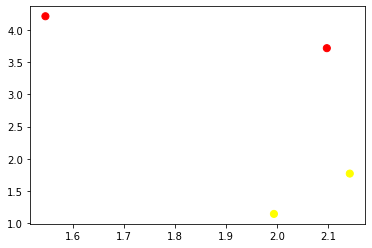

In [71]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=4, centers=2, random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

In [0]:
svm = SVM(C=100, max_iter=500)
svm.fit(X, 2.0 * (y - 0.5))

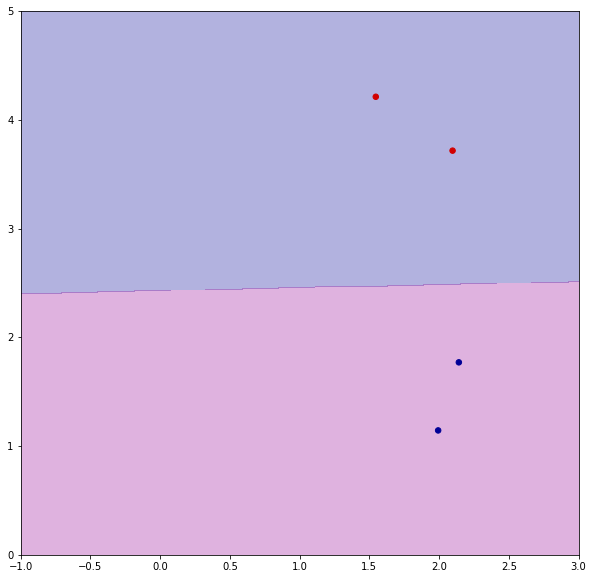

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def visualize(X, y):
  fig = plt.figure(figsize=(10,10))
  ax = fig.gca()
  #ax.tick_params(axis="y",direction="in", pad=-40)
  #ax.tick_params(axis="x",direction="in", pad=-15)
  #ax.set_xticks(np.arange(-.75, 1, .25))
  #ax.set_yticks(np.arange(-.75, 1, .25))
  
  # Plot the training points
  rgb = [[210, 0, 0], [0, 0, 150], [107, 142, 35], [150, 0, 150], [220, 105, 0]]
    
  rgb=np.array(rgb)/255.
  ax.scatter(X[:, 0], X[:, 1], c=rgb[y], s=30, zorder=3)
  ax.axis('tight')
  xlim = [-1, +3]
  ylim = [+0, +5]
  ax.set_xlim(xlim)
  ax.set_ylim(ylim)
  
  # fit the estimator
  xx, yy = np.meshgrid(np.linspace(*xlim, num=700), np.linspace(*ylim, num=700))
  Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])

  # Put the result into a color plot
  n_classes = 5
  Z = Z.reshape(xx.shape)
  #print(Z)
  contours = ax.contourf(xx, yy, Z, alpha=0.3, levels=[-1.0, 0.0, 1.0], cmap=ListedColormap(rgb), zorder=1)

  #plt.close(fig)

  #return fig
visualize(X, y)

In [64]:
print(2.0 * (y - 0.5))

[-1.  1.  1. -1. -1.  1. -1.  1. -1. -1. -1. -1. -1.  1.  1.  1. -1.  1.
 -1. -1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1. -1. -1.  1. -1.  1. -1.
 -1. -1.  1. -1.]
